In [116]:
import pandas as pd
import numpy as np
import os
import pickle
import tqdm

In [117]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [118]:
EUR_USD_FILE = "EUR_USD Historical Data.csv"
df = pd.DataFrame()
df = pd.read_csv(EUR_USD_FILE, index_col = False)
df = df.drop("Change", axis=1)

In [119]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.sort_index(ascending=True, inplace=True)

In [120]:
df.head()

,Price,Open,High,Low
Date,,,,
1979-12-27,1.5074,1.5074,1.5074,1.5074
1979-12-28,1.5076,1.5076,1.5076,1.5076
1979-12-31,1.5081,1.5081,1.5081,1.5081
1980-01-02,1.5149,1.5149,1.5149,1.5149
1980-01-03,1.5177,1.5177,1.5177,1.5177


In [121]:
%%time
windows = [3,5,9,14,30,60,90,120,150,300,500]
for window in windows:
    df[f"mean_{window}"] = df["Open"].rolling(window=window).mean()
    df[f"median_{window}"] = df["Open"].rolling(window=window).median()
    df[f"var_{window}"] = df["Open"].rolling(window=window).var()
    df[f"std_{window}"] = df["Open"].rolling(window=window).std()
    df[f"min_{window}"] = df["Open"].rolling(window=window).min()
    df[f"max_{window}"] = df["Open"].rolling(window=window).max()
    df[f"corr_{window}"] = df["Open"].rolling(window=window).corr()
    df[f"cov_{window}"] = df["Open"].rolling(window=window).cov()
    df[f"skew_{window}"] = df["Open"].rolling(window=window).skew()
    df[f"kurt_{window}"] = df["Open"].rolling(window=window).kurt()    

Wall time: 434 ms


In [122]:
df.columns

Index(['Price', 'Open', 'High', 'Low', 'mean_3', 'median_3', 'var_3', 'std_3',
       'min_3', 'max_3',
       ...
       'mean_500', 'median_500', 'var_500', 'std_500', 'min_500', 'max_500',
       'corr_500', 'cov_500', 'skew_500', 'kurt_500'],
      dtype='object', length=114)

In [123]:
df_train = df.drop(["High", "Open","Low"], axis=1).dropna(how='all').fillna(0)

X_tr = df_train.drop(["Price"],axis=1).values
y_tr = df_train["Price"].values

In [124]:
X_tr

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.50770000e+00,  1.50760000e+00,  1.30000000e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.13770000e+00,  1.13790000e+00,  1.90000004e-07, ...,
         1.59658260e-03, -7.74678056e-02,  4.15176004e-02],
       [ 1.13626667e+00,  1.13720000e+00,  5.49333334e-06, ...,
         1.57906649e-03, -5.90036478e-02,  3.38450327e-02],
       [ 1.13410000e+00,  1.13360000e+00,  1.35100000e-05, ...,
         1.56202673e-03, -3.97864678e-02,  2.38241501e-02]])

In [125]:
y_tr    

array([1.5074, 1.5076, 1.5081, ..., 1.134 , 1.1307, 1.1305])

In [131]:
%%time

from sklearn.metrics import mean_absolute_error,mean_squared_error

from sklearn.cluster import MeanShift
from sklearn import preprocessing, model_selection, neighbors, svm

from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

def ExecKerasModel():
    BATCH_SIZE = 1000
    EPOCHS = 1000
    #modelName = f"Keras_v5"
    #MaxBalance $314418 at Nov 12, 2008
    #Daily Income: $18
    #Monthly Income: $526
    #Gross Loss: $8224407, Gain: $8345896

    modelName = f"Keras_v7"
    model = Sequential(name=modelName)
    cb = keras.callbacks.TensorBoard(log_dir=f'./Keras/{modelName}/', 
                                histogram_freq=0, 
                                batch_size=BATCH_SIZE, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, 
                                embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

    if (os.path.exists(f"{model.name}.h5")):    
        model = load_model(f"{model.name}.h5")
        print("Model Loaded.", modelName)
    else:    
        print("Training Model", modelName)
        model.add(Dense(n_features, input_dim=n_features, activation='relu'))    
    
        model.add(Dense(40))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Dropout(0.25))  

        model.add(Dense(10))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Dropout(0.25))  
    
        model.add(Dense(1, activation='linear'))    
        model.compile(loss=['mse'], optimizer='adam', metrics=['mse', 'mae'])
        model.fit(X, y, validation_split = 0.3, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[cb], shuffle=True)
        model.save(f"{model.name}.h5")
        print("Model Saved.", modelName)
    print(model.summary())
    return model

def ExecRandomForestRegressor():
    modelName = f"RandomForest_1000Estimator"

    if (os.path.exists(f"{modelName}.pickle")):    
        pickle_in = open(f'{modelName}.pickle','rb')
        model = pickle.load(pickle_in)
        print("Model Loaded")
    else:
        model = RandomForestRegressor(n_estimators=1000,n_jobs=2,random_state=11,verbose=1)
        model.fit(X,y)
        with open(f"{modelName}.pickle",'wb') as f:
            pickle.dump(model, f)
            print('Model Saved')        

    return model

def ExecCatBoost():   
    modelName = f"CatBoost200"

    if (os.path.exists(f"{modelName}.pickle")):    
        pickle_in = open(f'{modelName}.pickle','rb')
        model = pickle.load(pickle_in)
        print("Model Loaded")
    else:
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X_tr, y_tr, test_size=0.2)
        model = CatBoostRegressor(iterations=200)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=[], use_best_model=True, verbose=True)
        with open(f"{modelName}.pickle",'wb') as f:
            pickle.dump(model, f)
            print('Model Saved')    
      
    return model
    
##model = ExecKerasModel()
##model = ExecRandomForestRegressor()
model = ExecCatBoost()

0:	learn: 1.1460844	test: 1.1488886	best: 1.1488886 (0)	total: 175ms	remaining: 34.8s
1:	learn: 1.1122819	test: 1.1150028	best: 1.1150028 (1)	total: 309ms	remaining: 30.6s
2:	learn: 1.0792126	test: 1.0818968	best: 1.0818968 (2)	total: 433ms	remaining: 28.4s
3:	learn: 1.0471708	test: 1.0498261	best: 1.0498261 (3)	total: 519ms	remaining: 25.5s
4:	learn: 1.0161472	test: 1.0188192	best: 1.0188192 (4)	total: 641ms	remaining: 25s
5:	learn: 0.9859170	test: 0.9885296	best: 0.9885296 (5)	total: 776ms	remaining: 25.1s
6:	learn: 0.9566043	test: 0.9591507	best: 0.9591507 (6)	total: 906ms	remaining: 25s
7:	learn: 0.9285462	test: 0.9310898	best: 0.9310898 (7)	total: 1.06s	remaining: 25.5s
8:	learn: 0.9009794	test: 0.9034812	best: 0.9034812 (8)	total: 1.2s	remaining: 25.5s
9:	learn: 0.8743951	test: 0.8769093	best: 0.8769093 (9)	total: 1.33s	remaining: 25.3s
10:	learn: 0.8486173	test: 0.8510995	best: 0.8510995 (10)	total: 1.47s	remaining: 25.3s
11:	learn: 0.8234768	test: 0.8260006	best: 0.8260006 (11)

STRATEGY TESTER
Wall time: 233 ms


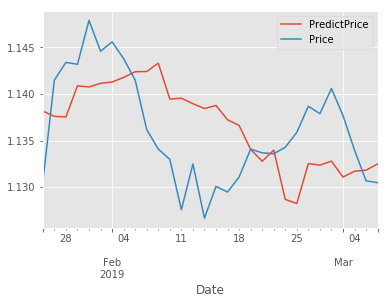

In [132]:
%%time
#STRATEGY TESTER
print("STRATEGY TESTER")
y_pred = model.predict(X_tr)
df["PredictPrice"] = y_pred

df[["PredictPrice","Price"]][-30:].plot()

2019-02-28 00:00:00 Open: 1.1379 Close: 1.1406 Sell Gain: $-118.0 Balance: $9882.0
2019-03-01 00:00:00 Open: 1.1372 Close: 1.1377 Sell Gain: $-22.0 Balance: $9860.0
2019-03-04 00:00:00 Open: 1.138 Close: 1.134 Sell Gain: $174.0 Balance: $10034.0
2019-03-05 00:00:00 Open: 1.1336 Close: 1.1307 Sell Gain: $129.0 Balance: $10162.0
2019-03-06 00:00:00 Open: 1.1307 Close: 1.1305 Buy Gain: $-9.0 Balance: $10154.0
MaxBalance $10162.0 at 2019-03-05 00:00:00
Daily Income: $31.0
Monthly Income: $921.0
Gross Loss: $149.0, Gain: $303.0


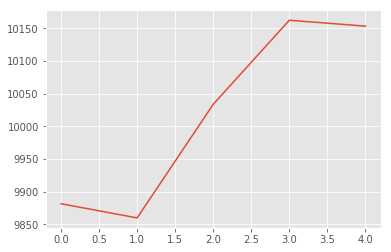

In [135]:
Init_Balance = 10_000
Balance = Init_Balance
Margin_Call = 0.1
Leverange = 5
MaxBalance = 0
MaxBalanceDate = None
StartDate = None
EndDate = None
Days = 0
GrossLoss = 0
GrossGain = 0
BalanceGraph = []

#for index, row in df.iterrows():
#for index, row in df[-365*1:].iterrows():
#for index, row in df[-365*2:][:365*1].iterrows():
#for index, row in df[-365*3:][:365*2].iterrows():
for index, row in df[-5*1:].iterrows():
    buy = row["PredictPrice"] > row["Open"]
    diff = (row["Price"] - row["Open"]) 
    change = diff / row["Price"]
    lossGain = change * Balance
    if buy == False:
        lossGain *= -1
    lossGain *= Leverange
    Balance += lossGain
    BalanceGraph.append(Balance)

    if (lossGain>0):
        GrossGain += abs(lossGain)
    else:
        GrossLoss += abs(lossGain)

    if (diff != 0):
        Days += 1
        if (StartDate == None):
            StartDate = index
        if buy: 
            actionStr = "Buy" 
        else: 
            actionStr = "Sell"
        print(index, f"Open: {row['Open']}", f"Close: {row['Price']}", f"{actionStr}", f"Gain: ${round(lossGain)}", f"Balance: ${round(Balance)}")

    if (MaxBalance < Balance):
        MaxBalance = Balance
        MaxBalanceDate = index

    EndDate = index

    if (Balance < Margin_Call*Init_Balance):        
        break       

print(f"MaxBalance ${round(MaxBalance)} at {MaxBalanceDate}")

DailyIncome = (Balance - Init_Balance) / (Days)
print(f"Daily Income: ${round(DailyIncome)}")
MontlyIncome = DailyIncome * 30
print(f"Monthly Income: ${round(MontlyIncome)}")
print(f"Gross Loss: ${round(GrossLoss)}, Gain: ${round(GrossGain)}")

plt.plot(BalanceGraph)
plt.show()